In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [13]:
log_path = Path("/home/ubuntu/repos/thesis/logs")

BATCH_SIZE = 128
DATASET = "compcars"

model_name = f"resnet18_bs_{BATCH_SIZE}"

model_path_prefix = "resnet18_pretrained_pid"

# Single training
train_path = log_path / "single_runs" / DATASET

# Shared data training
train_mul_path = log_path / "queues" / DATASET / model_name

naive_model_path_prefix = f"resnet18_pretrained_bs{BATCH_SIZE}_4tw_1vw_pid"
shared_model_path_prefix = f"resnet18_pretrained_bs{BATCH_SIZE}_4tw_1vw_1pf_pid"

if DATASET == "compcars":
    # CompCars, BS 128
    pids = [
        3458, 4976, 6108, 5311, # Naive
        3893, 6606, 6969, 7615, # MPS
        4507, 8313, 8549, 8833, # Shared
        4733, 9166, 9423, 9735, # Shared + MPS
    ]

    trace_pids = [
        3458, 4976, 6108, 5311, # Naive
        3893, 6606, 6969, 7615, # MPS
        4493, 8295, 8533, 8816, # Shared
        4720, 9151, 9407, 9718, # Shared + MPS
    ]
if DATASET == "imagenet64x64":
    pids = [
        11370, 11966, 12583, # Naive
         # MPS
         # Shared
         # Shared + MPS
    ]

    trace_pids = [
        11370, 11966, 12583, # Naive
         # MPS
         # Shared
         # Shared + MPS
    ]

In [14]:
# BASELINE

df_1x = pd.read_csv(train_path / model_name / f"{naive_model_path_prefix}_{pids[0]}.csv")
df_2x = pd.read_csv(train_path / model_name / f"{naive_model_path_prefix}_{pids[1]}.csv")
df_3x = pd.read_csv(train_path / model_name / f"{naive_model_path_prefix}_{pids[2]}.csv")
df_4x = pd.read_csv(train_path / model_name / f"{naive_model_path_prefix}_{pids[3]}.csv")

# BASELINE + MPS

df_1x_mps = pd.read_csv(train_path / model_name / f"{naive_model_path_prefix}_{pids[4]}.csv")
df_2x_mps = pd.read_csv(train_path / model_name / f"{naive_model_path_prefix}_{pids[5]}.csv")
df_3x_mps = pd.read_csv(train_path / model_name / f"{naive_model_path_prefix}_{pids[6]}.csv")
df_4x_mps = pd.read_csv(train_path / model_name / f"{naive_model_path_prefix}_{pids[7]}.csv")

# SHARED DATA

df_mul_1x = pd.read_csv(train_mul_path / f"{shared_model_path_prefix}_{pids[8]}.csv")
df_mul_2x = pd.read_csv(train_mul_path / f"{shared_model_path_prefix}_{pids[9]}.csv")
df_mul_3x = pd.read_csv(train_mul_path / f"{shared_model_path_prefix}_{pids[10]}.csv")
df_mul_4x = pd.read_csv(train_mul_path / f"{shared_model_path_prefix}_{pids[11]}.csv")

# SHARED DATA + MPS

df_mul_1x_mps = pd.read_csv(train_mul_path / f"{shared_model_path_prefix}_{pids[12]}.csv")
df_mul_2x_mps = pd.read_csv(train_mul_path / f"{shared_model_path_prefix}_{pids[13]}.csv")
df_mul_3x_mps = pd.read_csv(train_mul_path / f"{shared_model_path_prefix}_{pids[14]}.csv")
df_mul_4x_mps = pd.read_csv(train_mul_path / f"{shared_model_path_prefix}_{pids[15]}.csv")

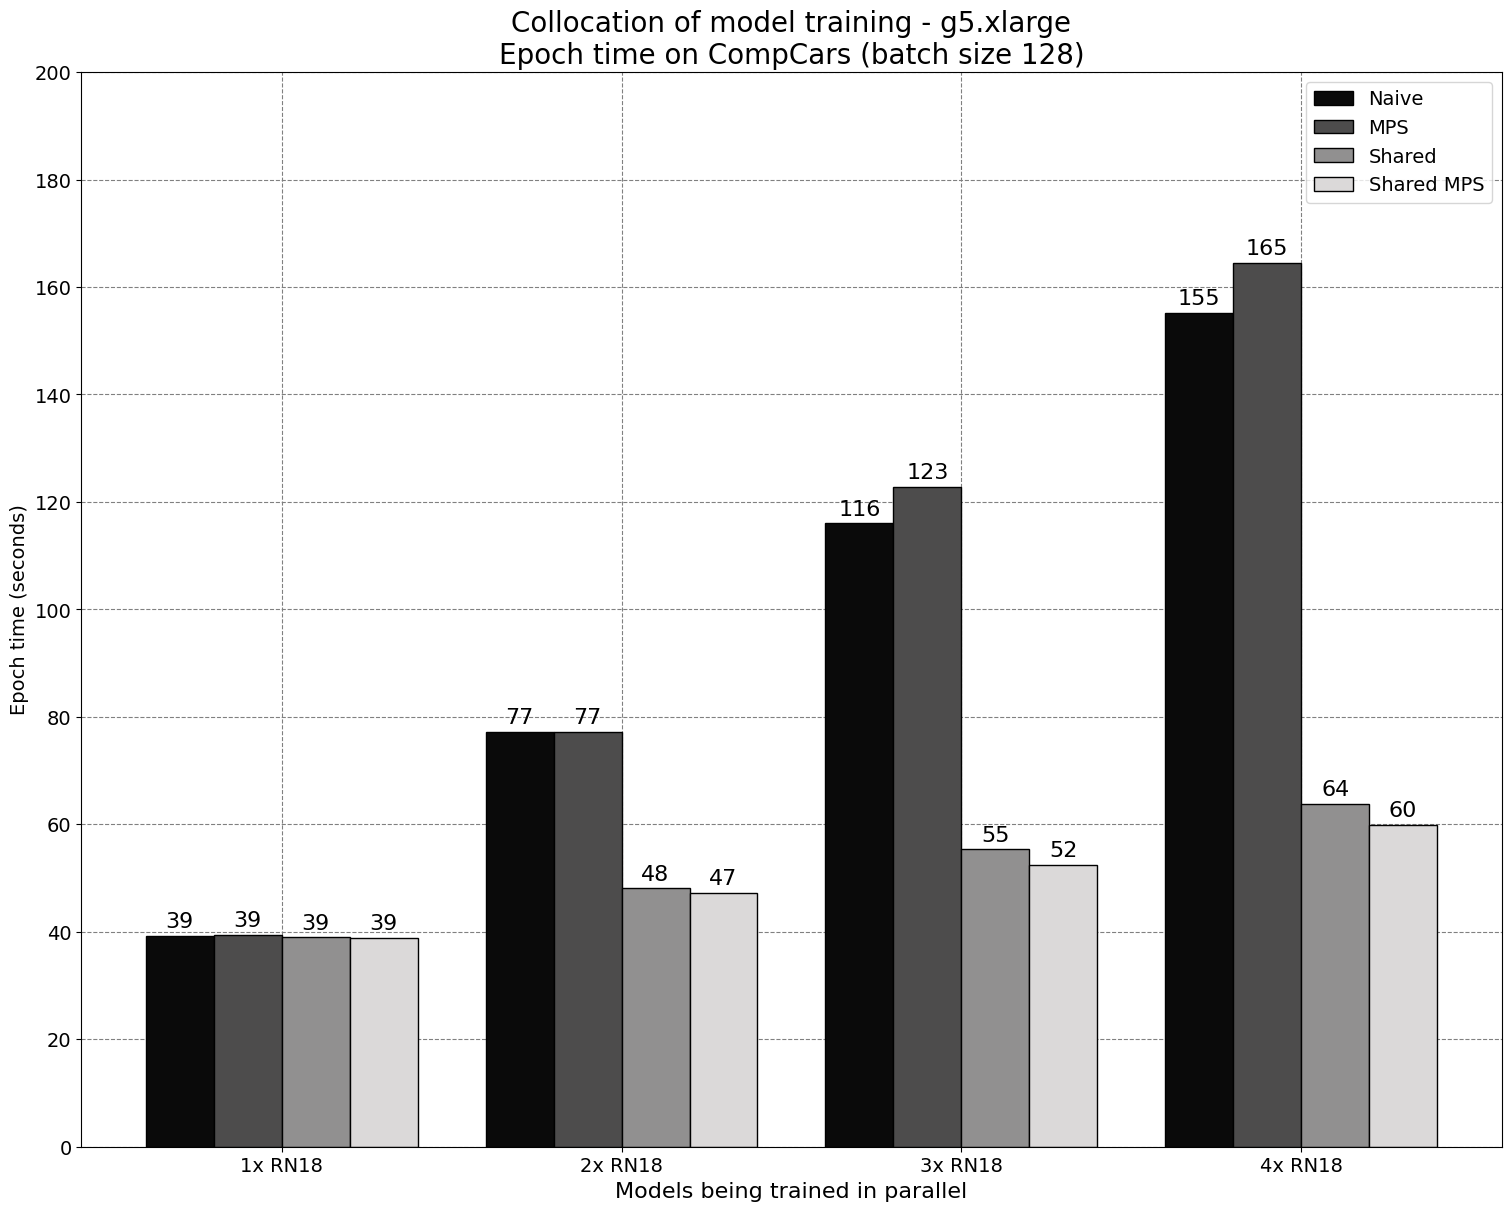

In [15]:
import matplotlib.pyplot as plt
import numpy as np

workloads = ("1x RN18", "2x RN18", "3x RN18", "4x RN18")

naive = [df.iloc[2:]["total_time"].mean() for df in [df_1x, df_2x, df_3x, df_4x]]

mps = [df.iloc[2:]["total_time"].mean() for df in [df_1x_mps, df_2x_mps, df_3x_mps, df_4x_mps]]

shared = [df.iloc[2:]["total_time"].mean() for df in [df_mul_1x, df_mul_2x, df_mul_3x, df_mul_4x]]

shared_mps = [df.iloc[2:-1]["total_time"].mean() for df in [df_mul_1x_mps, df_mul_2x_mps, df_mul_3x_mps, df_mul_4x_mps]]

measurements ={
    "Naive": naive,
    "MPS": mps,
    "Shared": shared,
    "Shared MPS": shared_mps,
}

x = np.arange(len(workloads))  # the label locations
width = 0.2  # the width of the bars
multiplier = -0.5

fig, ax = plt.subplots(layout='constrained', figsize=(15,12))
shades = ["#0a0a0a", "#4d4c4c", "#919090", "#dbd9d9"]

for idx, (attribute, measurement) in enumerate(measurements.items()):
    offset = width * multiplier
    #rects = ax.bar(x + offset, measurement, width, label=attribute, color=shades[idx], edgecolor="black", yerr=measurements_err[attribute][idx], ecolor="red", capsize=5)
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=shades[idx], edgecolor="black")
    ax.bar_label(rects, padding=3, fmt='%.0f', label_type="edge", color="black", size=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Epoch time (seconds)', fontsize=14)
ax.set_title(f'Collocation of model training - g5.xlarge\nEpoch time on CompCars (batch size {BATCH_SIZE})', fontsize=20)
ax.set_xticks(x + width, workloads, fontsize=14)
ax.legend(loc='upper right', fontsize=14)

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
plt.yticks([i for i in range(0, 201, 20)], fontsize=14)
plt.xlabel("Models being trained in parallel", fontsize=16)
plt.show()

In [ ]:
def create_plotable_df(plot_df, trace_pid, workload_type, ignore_pid=0, add_second=0):
    plot_df['date'] = pd.to_datetime(plot_df['timestamp'], unit="s", utc=True).dt.tz_convert('Europe/Berlin') - pd.DateOffset(hours=2) + pd.DateOffset(seconds=add_second)
    plot_df['time'] = plot_df["date"].dt.time

    start_time = str(plot_df["time"].iloc[0])
    end_time = str(plot_df["time"].iloc[-2])

    trace_header = ["date", "time", "gpu", "pid", "type", "sm", "mem", "enc", "dec", "mb", "command"]
    all_lines = []

    if workload_type in ("naive", "naive_mps"):
        trace_path = train_path / model_name / f"pid_{trace_pid}_gpu.out"
    elif workload_type in ("shared", "shared_mps"):
        trace_path = train_mul_path / f"pid_{trace_pid}_gpu.out"
    
    with open(trace_path, "r") as f:
        next(f)
        next(f)
        lines = f.readlines()
        lines = [line.strip().split() for line in lines]

    start_idx, end_idx = 0, 0
    while lines[start_idx][1] != start_time:
        start_idx += 1
    while lines[end_idx][1] != end_time:
        end_idx += 1
    all_lines=lines[start_idx:end_idx+1]

    clean_lines = []

    for l in all_lines:
        if l == ['#Date', 'Time', 'gpu', 'pid', 'type', 'sm', 'mem', 'enc', 'dec', 'fb', 'command']:
            continue
        elif l == ['#YYYYMMDD', 'HH:MM:SS', 'Idx', '#', 'C/G', '%', '%', '%', '%', 'MB', 'name']:
            continue
        elif l[-1] != "nvidia-cuda-mps" and "mps" in workload_type:
            continue
        elif int(l[2]) != 0:
            continue
        elif ignore_pid == int(l[3]):
            continue
        else:
            clean_lines.append(l)

    df = pd.DataFrame(clean_lines, columns=trace_header)

    df["sm"] = df["sm"].replace({"-": 0})
    df["mem"] = df["mem"].replace({"-": 0})

    df['sm'] = df['sm'].astype(int)
    df['mem'] = df['mem'].astype(int)

    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df['time_diff'] = (df['datetime'] - df['datetime'][0]).dt.total_seconds()

    return df

In [ ]:
def plot_heatmap(df, value="sm", title=""):
    max_val = df.iloc[-1]["time_diff"]

    plt.figure(figsize=(15,12))
    heatmap_data = df.pivot_table(index='time_diff', columns='pid', values=value)

    # Create a heatmap plot using seaborn
    ax = sns.heatmap(heatmap_data, cmap='gray_r', vmax=100,
                    yticklabels=[i if i % 25 == 0 else None for i in range(0, int(max_val))])
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
    # Add labels and title to the plot
    plt.xlabel('PID')
    plt.ylabel('Time (seconds)')
    #ax.set_yticks([float(i) for i in range(0, 251, 25)])
    ax.set_title(title + f"\n{value.upper()} %-utilization for each process over time", size=12)

    # Show the plot
    plt.show()

In [ ]:
def plot_timeseries(df, value, title):
    fig, ax = plt.subplots(figsize=(12,8))

    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df['time_diff'] = (df['datetime'] - df['datetime'][0]).dt.total_seconds()

    groups = df.groupby('pid')

    for pid, group in groups:
        l1 = f'PID {pid} {value.upper()} %'
        h1 = group.plot(kind='line', x='time_diff', y=value, ax=ax, label=l1)
        #ax.get_legend().remove()

        l2 = 'PID {} MEM %'.format(pid)
        h2 = group.plot(kind='line', x='time_diff', y='mem', ax=ax, color='r', label=l2)
        #ax2.get_legend().remove()

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Utilization %')
    ax.set_title(title, fontsize=12)
    plt.yticks([i for i in range(0, 101, 20)], fontsize=7)

    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
    plt.show()

In [ ]:
titles = [
    "Naive, 1x RN18, BS 128, g5.xlarge",
    "MPS, 1x RN18, BS 128, g5.xlarge",
    "Shared, 1x RN18, BS 128, g5.xlarge",
    "Shared + MPS, 1x RN18, 128, g5.xlarge"
]
ignore_pids = [0, 0, 46779, 0]
add_seconds = [0, 0, 0, 0]
workload_types = ["naive", "naive_mps", "shared", "shared_mps"]
trace_pids_1x = [trace_pids[0], trace_pids[4], trace_pids[8], trace_pids[12]]
for idx, df in enumerate([df_1x, df_1x_mps, df_mul_1x, df_mul_1x_mps]):

    plot_df = create_plotable_df(df, trace_pids_1x[idx], workload_types[idx], ignore_pid=ignore_pids[idx], add_second=add_seconds[idx])
    plot_timeseries(plot_df, "sm", titles[idx])

    #plot_heatmap(plot_df, "sm")
    #plot_heatmap(plot_df, "mem")
    

In [ ]:
titles = [
    "Naive, 2x RN18, BS 128, g5.xlarge",
    "MPS, 2x RN18, BS 128, g5.xlarge",
    "Shared, 2x RN18, BS 128, g5.xlarge",
    "Shared + MPS, 2x RN18, BS 128, g5.xlarge"
]
ignore_pids = [0, 0, 47048, 0]
add_seconds = [0, 0, 0, 0]
workload_types = ["naive", "naive_mps", "shared", "shared_mps"]
trace_pids_2x = [trace_pids[1], trace_pids[5], trace_pids[9], trace_pids[13]]
for idx, df in enumerate([df_2x, df_2x_mps, df_mul_2x, df_mul_2x_mps]):

    plot_df = create_plotable_df(df, trace_pids_2x[idx], workload_types[idx], ignore_pid=ignore_pids[idx], add_second=add_seconds[idx])
    plot_timeseries(plot_df, "sm", titles[idx])

    plot_heatmap(plot_df, "sm", titles[idx])
    plot_heatmap(plot_df, "mem", titles[idx])
    

In [ ]:
titles = [
    "Naive, 4x RN18, BS 128, g5.xlarge",
    "MPS, 4x RN18, BS 128, g5.xlarge",
    "Shared, 4x RN18, BS 128, g5.xlarge",
    "Shared + MPS, 4x RN18, BS 128, g5.xlarge"
]
ignore_pids = [0, 0, 47744, 0]
add_seconds = [0, 0, 0, 0]
workload_types = ["naive", "naive_mps", "shared", "shared_mps"]
trace_pids_4x = [trace_pids[3], trace_pids[7], trace_pids[11], trace_pids[15]]
for idx, df in enumerate([df_4x, df_4x_mps, df_mul_4x, df_mul_4x_mps]):

    plot_df = create_plotable_df(df, trace_pids_4x[idx], workload_types[idx], ignore_pid=ignore_pids[idx], add_second=add_seconds[idx])
    plot_timeseries(plot_df, "sm", titles[idx])

    plot_heatmap(plot_df, "sm", titles[idx])
    plot_heatmap(plot_df, "mem", titles[idx])
    